In [1]:
import torch
from torch import nn

from train import train, get_weighted_single_eval_pos_sampler
import priors
import encoders
import positional_encodings
import decoders

from datasets import *
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy import special  
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import numpy as np
from train import Losses

from copy import deepcopy
from sklearn import neighbors, datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from scripts import tabular_evaluation
from scripts import tabular_baselines
import datetime

In [2]:
import seaborn as sns
import pickle
from tqdm import tqdm
import os
import random
import numpy as np

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, open_cc_dids
from priors.utils import order_by_y, plot_prior, plot_features
from utils import normalize_data, normalize_by_used_features_f
from priors.utils import trunc_norm_sampler_f, beta_sampler_f, gamma_sampler_f, uniform_sampler_f, zipf_sampler_f, scaled_beta_sampler_f, uniform_int_sampler_f
from scripts.tabular_baselines import *
from scripts.model_builder import get_default_spec, get_model
from scripts.tabular_evaluation import evaluate
from scripts.tabular_metrics import calculate_score_per_method, calculate_score, make_ranks_and_wins_table, make_metric_matrix
from scripts import tabular_metrics
import openml

In [3]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager

In [4]:
%load_ext autoreload

%autoreload 2

# Preparation

## Datasets

In [5]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples=2000, num_feats=100, return_capped=True)


Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..


## Parameters and functions

In [6]:
def get_datasets(selector, task_type, suite='openml'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [7]:
device = 'cpu'

def eval_method(task_type, method, dids, selector, eval_positions, max_time, metric_used, split_number, append_metric=True, fetch_only=False, verbose=False):
    
    dids = dids if type(dids) is list else [dids]
    
    for did in dids:

        ds = get_datasets(selector, task_type, suite=suite)

        ds = ds if did is None else ds[did:did+1]

        clf = clf_dict[method]

        time_string = '_time_'+str(max_time) if max_time else ''
        metric_used_string = '_'+tabular_baselines.get_scoring_string(metric_used, usage='') if append_metric else ''

        result = evaluate(datasets=ds
                          , model=clf
                          , method=method+time_string+metric_used_string
                          , bptt=bptt, base_path=base_path
                          , eval_positions=eval_positions
                          , device=device, max_splits=1
                          , overwrite=overwrite
                          , save=True
                          , metric_used=metric_used
                          , path_interfix=task_type
                          , fetch_only=fetch_only
                          , split_number=split_number
                          , verbose=verbose
                          , max_time=max_time)
    
    return result

In [8]:
relabeler = {'tab_transformer': 'TabPFN'
            , 'i_transformer_2_1': 'iTabPFN'
            , 'autosklearn2': 'Autosklearn2'
            , 'autosklearn': 'Autosklearn'
            , 'lgbm': 'LGBM'
            , 'gp': 'GP (RBF)'
            , 'logistic': 'Log. Regr.'
            , 'knn': 'KNN'
            , 'xgb': 'XGB'}

In [9]:
clf_dict= {
            'gp': gp_metric 
          , 'knn': knn_metric
          , 'xgb': xgb_metric
          , 'i_transformer_2_1': transformer_metric # our iTabPFN - trained 12h
          , 'tab_transformer': transformer_metric # original TabPFN - trained 12h
          , 'logistic': logistic_metric
          , 'autosklearn': autosklearn_metric
          , 'autosklearn2': autosklearn2_metric
          , 'lgbm': lightgbm_metric 
          }

In [10]:
suite = 'cc'
task_type = 'multiclass'
selector = 'test'
bptt = 2000

eval_positions = [1000]
pos = str(eval_positions[0])

base_path = os.path.join('.')
metric_used = tabular_metrics.auc_metric

## Test datasets

In [11]:
task_type = 'multiclass'
suite = 'cc'
test_datasets = get_datasets('test',task_type, suite=suite)

[(i, test_datasets[i][0]) for i in range(len(test_datasets))]

[(0, 'balance-scale'),
 (1, 'mfeat-fourier'),
 (2, 'breast-w'),
 (3, 'mfeat-karhunen'),
 (4, 'mfeat-morphological'),
 (5, 'mfeat-zernike'),
 (6, 'cmc'),
 (7, 'credit-approval'),
 (8, 'credit-g'),
 (9, 'diabetes'),
 (10, 'tic-tac-toe'),
 (11, 'vehicle'),
 (12, 'eucalyptus'),
 (13, 'analcatdata_authorship'),
 (14, 'analcatdata_dmft'),
 (15, 'pc4'),
 (16, 'pc3'),
 (17, 'kc2'),
 (18, 'pc1'),
 (19, 'banknote-authentication'),
 (20, 'blood-transfusion-service-center'),
 (21, 'ilpd'),
 (22, 'qsar-biodeg'),
 (23, 'wdbc'),
 (24, 'cylinder-bands'),
 (25, 'dresses-sales'),
 (26, 'MiceProtein'),
 (27, 'car'),
 (28, 'steel-plates-fault'),
 (29, 'climate-model-simulation-crashes')]

In [12]:
print(len(test_datasets),"- all test datasets")

# filters that will be used later on
test_datasets_multiclass_filtered__ = test_datasets
test_datasets_multiclass_filtered_U2 = [ds for ds in test_datasets_multiclass_filtered__ if len(ds[3]) == 0 and not torch.isnan(ds[1]).any()]
print(len(test_datasets_multiclass_filtered_U2),"- no categorical, no NANs")

test_datasets_multiclass_filtered__ = test_datasets
test_datasets_multiclass_filtered_U1 = [ds for ds in test_datasets_multiclass_filtered__ if len(ds[3]) == 0 and torch.isnan(ds[1]).any()]
print(len(test_datasets_multiclass_filtered_U1)," - no categorical, with NANs")

test_datasets_multiclass_filtered__ = test_datasets
test_datasets_multiclass_filtered_U0 = [ds for ds in test_datasets_multiclass_filtered__ if len(ds[3]) != 0 and not torch.isnan(ds[1]).any()]
print(len(test_datasets_multiclass_filtered_U0)," - only categorical, no NANs")

test_datasets_multiclass_filtered__ = test_datasets
test_datasets_multiclass_filtered_U = [ds for ds in test_datasets_multiclass_filtered__ if len(ds[3]) != 0 and torch.isnan(ds[1]).any()]
print(len(test_datasets_multiclass_filtered_U)," - only categorical, with NANs")

30 - all test datasets
18 - no categorical, no NANs
2  - no categorical, with NANs
6  - only categorical, no NANs
4  - only categorical, with NANs


## Global results

In [13]:
# loading the results

# Execution failed <dataset_name> - no need to worry, some models did not have meaningful results for small time budgets so they are not loaded

global_results = {}
overwrite=False

methods = ['tab_transformer',
           'i_transformer_2_1',
           'logistic',
           'knn',
           'gp',
           'lgbm',
           'xgb',
           'autosklearn',
           'autosklearn2',
           ]

max_times = [0.5, 1, 5, 30, 60, 60*5, 60*30]

for method in methods:
    print(f">> method: {method}")
    for max_time in max_times:
        for split_number in range(1,5+1):
            global_results[method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)] = eval_method(task_type, method,  None, selector, 
                                                                                                                                    eval_positions, fetch_only=True, 
                                                                                                                                    verbose=False, max_time=max_time,
                                                                                                                                    metric_used=metric_used, split_number=split_number)

>> method: tab_transformer
>> method: i_transformer_2_1
>> method: logistic
>> method: knn
>> method: gp
>> method: lgbm
Execution failed balance-scale
Execution failed mfeat-fourier
Execution failed breast-w
Execution failed mfeat-karhunen
Execution failed mfeat-morphological
Execution failed mfeat-zernike
Execution failed cmc
Execution failed credit-approval
Execution failed credit-g
Execution failed diabetes
Execution failed tic-tac-toe
Execution failed vehicle
Execution failed eucalyptus
Execution failed analcatdata_authorship
Execution failed analcatdata_dmft
Execution failed pc4
Execution failed pc3
Execution failed kc2
Execution failed pc1
Execution failed banknote-authentication
Execution failed blood-transfusion-service-center
Execution failed ilpd
Execution failed qsar-biodeg
Execution failed wdbc
Execution failed cylinder-bands
Execution failed dresses-sales
Execution failed MiceProtein
Execution failed car
Execution failed steel-plates-fault
Execution failed climate-model-s

In [14]:
limit_to = ''
calculate_score(tabular_metrics.auc_metric, 'roc', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.cross_entropy, 'cross_entropy', global_results, test_datasets, eval_positions + [-1], limit_to=limit_to)
calculate_score(tabular_metrics.accuracy_metric, 'acc', global_results, test_datasets, eval_positions + [-1])
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)
calculate_score(tabular_metrics.time_metric, 'time', global_results, test_datasets, eval_positions + [-1], aggregator='mean', limit_to=limit_to)
calculate_score(tabular_metrics.count_metric, 'count', global_results, test_datasets, eval_positions + [-1], aggregator='sum', limit_to=limit_to)

# Comparison of Methods

## Time budget plots

### Mean ROC AUC

In [15]:
def generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix):
    global_results_filtered_split = {**global_results_filtered}
    global_results_filtered_split = {k: global_results_filtered_split[k] for k in global_results_filtered_split.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number) in k or 'transformer_split_'+str(split_number) in k}

    matrix, matrix_stds, _ = make_metric_matrix(global_results_filtered_split, methods, pos, metric_key, test_datasets)
    
    for method in methods:
        if time_matrix[method] > max_time * 2:
            matrix[method] = np.nan

    if metric_key == 'cross_entropy':
        matrix = -(matrix.fillna(-100))
    else:
        matrix = matrix.fillna(-1)

    return make_ranks_and_wins_table(matrix.copy())

In [16]:
%matplotlib inline

df_ = []
metric_keys = ['roc', 'cross_entropy', 'time']
max_times = [0.5, 1, 5, 30, 60, 60*5, 60*30]

for max_time in max_times:
    print(f">> max_time {max_time}")
    global_results_filtered = {**global_results}
    global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k or 'transformer' in k}
    
    time_matrix, _, _  = make_metric_matrix(global_results_filtered, methods, pos, 'time', test_datasets)
    time_matrix = time_matrix.mean()
    
    if len(global_results_filtered) == 0:
        continue
        
    # Calculate ranks and wins per split
    for metric_key in metric_keys:
        for split_number in range(1,6):
            ranks, wins = generate_ranks_and_wins_table(global_results_filtered, metric_key, max_time, split_number, time_matrix)
            for method in methods:
                method_ = method+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='') 
                global_results[method_+'_split_'+str(split_number)]['mean_rank_'+metric_key+f'_at_{pos}'] = ranks[method]
                global_results[method_+'_split_'+str(split_number)]['mean_wins_'+metric_key+f'_at_{pos}'] = wins[method]
    
    avg_times = {}
    for method_ in methods:
        avg_times[method_] = []
        for split_number in range(1,6):
            if method_ != 'transformer':
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
            else:
                method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)

            avg_times[method_] += [global_results[method][f'mean_time_at_{pos}']]
    avg_times = pd.DataFrame(avg_times).mean()
    
    for metric_key in metric_keys:
        for ranking in ['', 'rank_', 'wins_']:
            for method_ in methods:
                for split_number in range(1,6):
                    method = method_
                    if method_ != 'transformer':
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)
                    else:
                        method = method_+'_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_split_'+str(split_number)

                    if global_results[method][f'sum_count_at_{pos}'] <= 29:
                        print('Warning not all datasets generated for '+method+' '+ str(global_results[method][f'sum_count_at_{pos}']))
                        
                    time = global_results[method]['mean_time'] if ranking == '' else max_time
                    time = max_time 
                    df_ += [{'metric'+ranking+metric_key: global_results[method]['mean_'+ranking+metric_key+f'_at_{pos}'], 'real_time': avg_times[method_], 'time': time, 'method': method_, 'split_number': split_number}]
                            
            
df_ = pd.DataFrame(df_)

>> max_time 0.5
>> max_time 1
>> max_time 5
>> max_time 30
>> max_time 60
>> max_time 300
>> max_time 1800
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_1 26.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_2 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_3 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_4 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_5 28.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_1 26.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_2 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_3 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_4 29.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_5 28.0
Warning not all datasets generated for autosklearn_time_1800roc_auc_split_1 26.0
Wa

In [17]:
metric_renamer = {'roc': 'Mean ROC AUC', 'cross_entropy': 'Cross entropy'
                  , 'rank_roc': 'Mean ROC AUC Rank', 'rank_cross_entropy': 'Mean Cross entropy Rank'
                  , 'wins_roc': 'Mean ROC AUC Wins', 'wins_cross_entropy': 'Mean Cross entropy Wins'
                  , 'time': 'actual time taken'}
max_times_renamer = {0.5: "0.5s", 1: "1s", 5: "5s", 15: "15s", 30: "30s", 60: "1min", 300: "5min", 900: "15min", 1800: "30min", 3600: "1h", 14400: "4h"}

def make_tabular_results_plot(metric_key, exclude, max_times, df_, grouping=True, star=False, fig_size=(7,7), color_scheme='colorblind'):
    f, ax = plt.subplots(figsize=fig_size)
    
    df_.loc[:, 'time_log'] = np.log10(df_.time)
    df_.loc[:, 'real_time_log'] = np.log10(df_.real_time)
    time_column = 'time_log' if grouping else 'real_time_log'

    sns.set_palette(color_scheme)

    for method in df_.method.unique()[::-1]:
        if method in exclude:
            continue
        if 'tab_transformer' in method:
            k = 'tab_transformer'
            df_trans = df_[df_.method==k]
            df_trans = df_trans[~df_trans['metric'+metric_key].isna()]
            if star:
                # Removing dots for line for transformers
                df_trans = df_trans[np.logical_or(df_trans.real_time == df_trans.real_time.min(), df_trans.real_time == df_trans.real_time.max())]
                df_trans.loc[:, 'metric'+metric_key] = df_trans['metric'+metric_key].mean()
                df_trans.loc[:, time_column] = np.log10(0.55) 
            ax = sns.lineplot(x=time_column, y='metric'+metric_key, data=df_trans, linestyle='--', marker='o', ci=None, ax=ax, label=relabeler[k])
        elif 'i_transformer_2_1' in method:
            j = 'i_transformer_2_1'
            df_trans = df_[df_.method==j]
            df_trans = df_trans[~df_trans['metric'+metric_key].isna()]
            if star:
                # Removing dots for line for transformers
                df_trans = df_trans[np.logical_or(df_trans.real_time == df_trans.real_time.min(), df_trans.real_time == df_trans.real_time.max())]
                df_trans.loc[:, 'metric'+metric_key] = df_trans['metric'+metric_key].mean()
                df_trans.loc[:, time_column] = np.log10(0.55) 
            ax = sns.lineplot(x=time_column, y='metric'+metric_key, data=df_trans, linestyle='--', marker='o', ci=None, ax=ax, label=relabeler[j])
        else:
            df_method = df_[df_.method==method].copy()
            ax = sns.lineplot(x=time_column, y='metric'+metric_key, data=df_method, marker='o', ci=95, label=relabeler[method], ax=ax)
        

    if grouping:
        ax.set_xlabel("Given Time Budget")
    else:
        ax.set_xlabel("Given Time Budget")
    ax.set_ylabel(metric_renamer[metric_key])

    # ax.legend()
    
    times = np.log10(max_times)
    ax.set_xticks(times)
    ax.set_xticklabels([max_times_renamer[t] for t in max_times])
    
    return ax

In [18]:
df_absolute = df_.copy()

In [19]:
df_absolute.drop(df_absolute[(df_absolute.method == "i_transformer_2_1") & ((df_absolute.time > 5) & (df_absolute.time <= 300))].index, inplace=True)
df_absolute.drop(df_absolute[(df_absolute.method == "tab_transformer") & ((df_absolute.time > 5) & (df_absolute.time <= 300))].index, inplace=True)
df_absolute.drop(df_absolute[(df_absolute.method == "autosklearn") & (df_absolute.time == 30)].index, inplace=True)
df_absolute.drop(df_absolute[(df_absolute.method == "autosklearn2") & (df_absolute.time == 60)].index, inplace=True)
df_absolute.drop(df_absolute[(df_absolute.time == 0.5)].index, inplace=True)

In [20]:
df_absolute = df_absolute.sort_values(by=['method'])

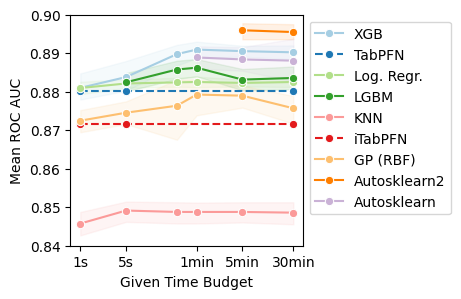

In [22]:
cs = 'Paired'

max_times=[1, 5, 60, 60*5, 60*30]
fig_size=(3,3)

ax = make_tabular_results_plot('roc', df_=df_absolute, exclude=[], fig_size=fig_size, grouping=True, max_times=max_times, star=False, color_scheme=cs)
ax.set_ylim([0.84, 0.90])
ax.set_xlim([np.log10(0.7), np.log10(2500)])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for c in ax.collections:
    c.set_alpha(.1)

### Mean ROC AUC Wins (not used)

In [23]:
df_absolute1 = df_.copy()

In [24]:
df_absolute1.drop(df_absolute1[(df_absolute1.method == "autosklearn") & (df_absolute1.time == 30)].index, inplace=True)
df_absolute1.drop(df_absolute1[(df_absolute1.method == "autosklearn2") & (df_absolute1.time == 60)].index, inplace=True)
df_absolute1.drop(df_absolute1[(df_absolute1.time == 0.5)].index, inplace=True)

In [25]:
df_absolute1 = df_absolute1.sort_values(by=['method'])

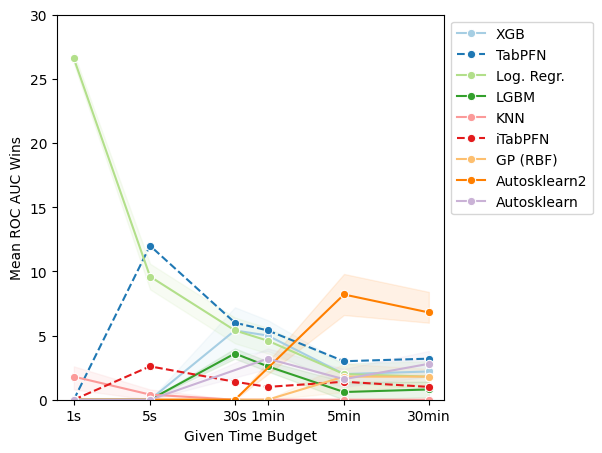

In [26]:
cs = 'Paired'

max_times=[1, 5, 30, 60, 60*5, 60*30]
fig_size=(5,5)

ax = make_tabular_results_plot('wins_roc', df_=df_absolute1[df_absolute1.time >= 1].copy(), exclude=[], fig_size=fig_size, max_times=max_times, color_scheme=cs)
ax.set_xlim([np.log10(0.7), np.log10(2500)])
ax.set_ylim([0, 30])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for c in ax.collections:
    c.set_alpha(.1)


### Mean ROC AUC Ranks (not used)

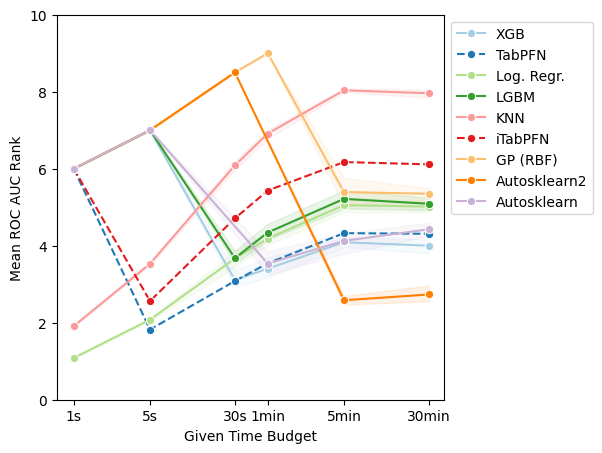

In [27]:
cs = 'Paired'

max_times=[1, 5, 30, 60, 60*5, 60*30]
fig_size=(5,5)

ax = make_tabular_results_plot('rank_roc', df_=df_absolute1[df_absolute1.time >= 1].copy(), exclude=[], fig_size=fig_size, max_times=max_times, color_scheme=cs)
ax.set_xlim([np.log10(0.7), np.log10(2500)])
ax.set_ylim([0, 10])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for c in ax.collections:
    c.set_alpha(.1)

## Performance for dataset characteristics

### Categorical and NANs 1

In [28]:
methods_vis = ['tab_transformer',
               'i_transformer_2_1',
               'gp',
               'lgbm',
               'xgb',
               'autosklearn',
               'autosklearn2',
               ]

In [29]:
max_time = '1800'
metric_used = tabular_metrics.auc_metric

In [30]:
global_results_filtered = {**global_results}
global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k}

print(f"{len(global_results_filtered)}: global_results_filtered") # 45 = 9methods * 5splits

45: global_results_filtered


In [31]:
test_datasets_multiclass_filtered = test_datasets

print(f"{len(test_datasets)}: test_datasets") # 30
print(f"{len(test_datasets_multiclass_filtered)}: test_datasets_multiclass_filtered") # 30

30: test_datasets
30: test_datasets_multiclass_filtered


In [32]:
sum_matrix, sum_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_vis, pos, 'count', test_datasets_multiclass_filtered)
roc_matrix, roc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_vis, pos, 'roc', test_datasets_multiclass_filtered)
acc_matrix, acc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_vis, pos, 'acc', test_datasets_multiclass_filtered)

cross_entropy_matrix, cross_entropy_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_vis, pos, 'cross_entropy', test_datasets_multiclass_filtered)
time_matrix, time_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_vis, pos, 'time', test_datasets_multiclass_filtered)

roc_rank, rocs_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())

cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())
roc_matrix_norm = ((roc_matrix.T - roc_matrix.min(1)) / (roc_matrix.max(1) - roc_matrix.min(1))).T

In [33]:
df_ = []
for i, dss in [(x, test_datasets[x][0]) for x in range(len(test_datasets))]:
    for j, method_ in enumerate(methods_vis):
        metric = roc_matrix.loc[dss, method_]
        df_ += [{'id': j, 'metric': metric, 'dataset_name': dss
                 , 'dataset_feats': test_datasets[i][1].shape[1]
                 , 'dataset_samples': test_datasets[i][1].shape[0]
                 , 'nan_prob': float(torch.mean(torch.isnan(test_datasets[i][1]).float()))
                 , 'cat_prob': len(test_datasets[i][3])/(test_datasets[i][1].shape[1])
                 , 'dataset_classes': len(np.unique(test_datasets[i][2]))
                 , 'skew': np.std(np.unique(test_datasets[i][2], return_counts=True)[1] / len(test_datasets[i][2]))
                 , 'method': relabeler[method_]}]

In [34]:
df_ = pd.DataFrame(df_)


In [35]:
df_.loc[:, 'is_categorical'] = df_.cat_prob > 0.0
df_.loc[:, 'has_nans'] = df_.nan_prob > 0.0
df_.loc[:, 'multiclass'] = df_.dataset_classes > 2
df_.loc[:, 'dataset_feats_big'] = df_.dataset_feats > 18
df_.loc[:, 'dataset_samples_big'] = df_.dataset_samples > 900

df_.loc[:, 'is_cat_no_nans'] = (df_.cat_prob > 0.0) & (df_.nan_prob == 0.0)

In [36]:
# comparison

# 6 datasets: cat and NO nans
print(f"TabPFN on datasets which: have no cat (False): {df_[(df_.method=='TabPFN') & (df_.cat_prob == 0) & (df_.has_nans == False)]['metric'].mean()}")
print(f"TabPFN on datasets which: has cat (True): {df_[(df_.method=='TabPFN') & (df_.cat_prob > 0) & (df_.has_nans == False)]['metric'].mean()}") 

print(f"iTabPFN on datasets which: have no cat (False): {df_[(df_.method=='iTabPFN') & (df_.is_categorical == False) & (df_.has_nans == False)]['metric'].mean()}")
print(f"iTabPFN on datasets which: has cat (True): {df_[(df_.method=='iTabPFN') & (df_.is_categorical == True) & (df_.has_nans == False)]['metric'].mean()}") 

## 6 datasets: cat and NO nans
# has no cat (NO): 0.928634865376
# has cat (YES): 0.7561388404014342
# has no cat (NO): 0.9149525041980736
# has cat (YES): 0.7588861861914435

TabPFN on datasets which: have no cat (False): 0.928634865376
TabPFN on datasets which: has cat (True): 0.7561388404014342
iTabPFN on datasets which: have no cat (False): 0.9149525041980736
iTabPFN on datasets which: has cat (True): 0.7588861861914435


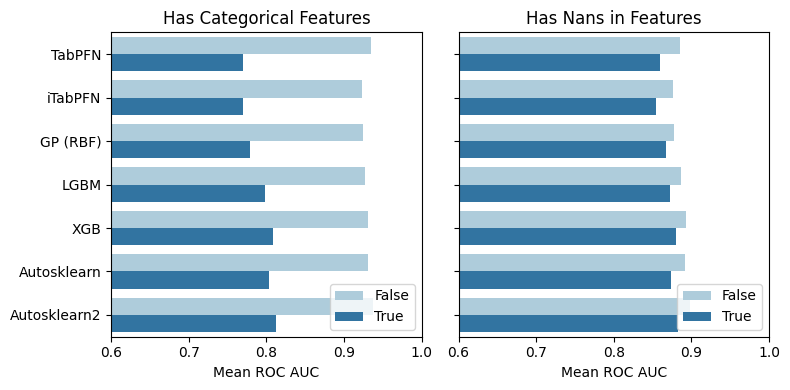

In [37]:
sns.color_palette("Paired")
fig, ax = plt.subplots(1,2,figsize=(8, 4), sharey=True)
hue_dict = {
            'is_categorical': 'Has Categorical Features'
            ,'is_cat_no_nans': 'Has Categ. Ft. & No NANs'
            , 'has_nans': 'Has Nans in Features', 'multiclass': 'Multiclass'
            , 'dataset_feats_big': 'More than 20 features', 'dataset_samples_big': 'aa'}
for i, hue in enumerate(['is_categorical', 'has_nans']):
    ax_ = ax[i]
    g = sns.barplot(data=df_, x='metric', y='method', hue=hue, ax=ax_, ci=None)
    ax_.title.set_text(hue_dict[hue])
    ax_.set(ylabel=None, xlabel='Mean ROC AUC') 
    g.legend(title='')
    ax_.set_xlim([0.6, 1.0])
    ax_.legend(title='', loc='lower right', labels=['False', 'True']) 
plt.tight_layout()

### Categorical and NANs 2

In [38]:
df_ = []
for i, dss in [(x, test_datasets[x][0]) for x in range(len(test_datasets))]:
    for j, method_ in enumerate(methods_vis):
        metric = roc_matrix.loc[dss, method_]
        df_ += [{'id': j, 'metric': metric, 'dataset_name': dss
                 , 'dataset_feats': test_datasets[i][1].shape[1]
                 , 'dataset_samples': test_datasets[i][1].shape[0]
                 , 'nan_prob': float(torch.mean(torch.isnan(test_datasets[i][1]).float()))
                 , 'cat_prob': len(test_datasets[i][3])/(test_datasets[i][1].shape[1])
                 , 'dataset_classes': len(np.unique(test_datasets[i][2]))
                 , 'skew': np.std(np.unique(test_datasets[i][2], return_counts=True)[1] / len(test_datasets[i][2]))
                 , 'method': relabeler[method_]}]

In [39]:
df_ = pd.DataFrame(df_)

In [40]:
df_.loc[:, 'is_categorical'] = df_.cat_prob > 0.0
df_.loc[:, 'has_nans'] = df_.nan_prob > 0.0
df_.loc[:, 'multiclass'] = df_.dataset_classes > 2
df_.loc[:, 'dataset_feats_big'] = df_.dataset_feats > 18
df_.loc[:, 'dataset_samples_big'] = df_.dataset_samples > 900

/Users/Ugne/opt/anaconda3/envs/DL_project_new/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <BarContainer object of 4 artists> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


(0.0, 1.0)

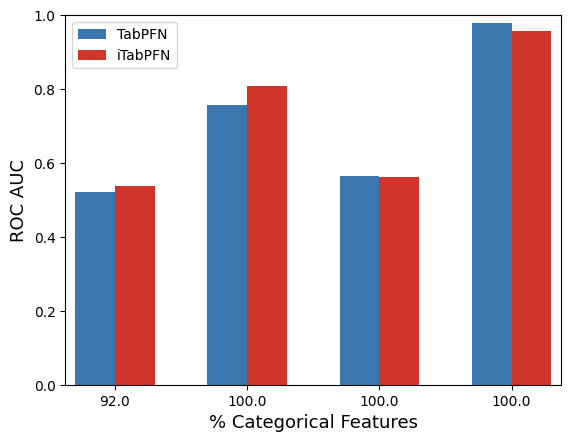

In [41]:
chart1 = df_[(df_.method=='TabPFN') & (df_.cat_prob >= 0.8) & (df_.nan_prob >= 0.0)].sort_values(by=['cat_prob'])
chart1['cat_prob'] = chart1['cat_prob'].round(2)
chart1['cat_prob'] = chart1['cat_prob'].multiply(100)
ax1 = chart1.plot(x = 'cat_prob', y='metric', kind = 'bar', color = '#3C76AF', alpha = 1, width = 0.3, position = 1, label = 'TabPFN', rot = 0)

ichart1 = df_[(df_.method=='iTabPFN') & (df_.cat_prob > 0.8) & (df_.nan_prob >= 0.0)].sort_values(by=['cat_prob'])
ichart1['cat_prob'] = ichart1['cat_prob'].round(2)
ichart1['cat_prob'] = ichart1['cat_prob'].multiply(100)
ichart1 = ichart1.plot(x = 'cat_prob', y='metric', kind = 'bar', ax = ax1, color = '#D0352B', alpha = 1, width = 0.3, position = 0, label = 'iTabPFN', rot = 0)

iichart1 = df_[(df_.method=='iTabPFN') & (df_.cat_prob > 0.8) & (df_.nan_prob >= 0.0)].sort_values(by=['cat_prob'])
iichart1['cat_prob'] = iichart1['cat_prob'].round(2)
iichart1['cat_prob'] = iichart1['cat_prob'].multiply(100)
iichart1 = iichart1.plot(x = 'cat_prob', y='metric', kind = 'bar', ax = ax1, color = '#D0352B', alpha = 0, width = 0.25, position = 0.5, label = '_', rot = 0)

ichart1.set_xlabel("% Categorical Features", fontsize = 13)
ichart1.set_ylabel("ROC AUC", fontsize = 13)

ichart1.set_ylim(0, 1)

/Users/Ugne/opt/anaconda3/envs/DL_project_new/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:633: UserWarning: The handle <BarContainer object of 2 artists> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


(0.0, 1.0)

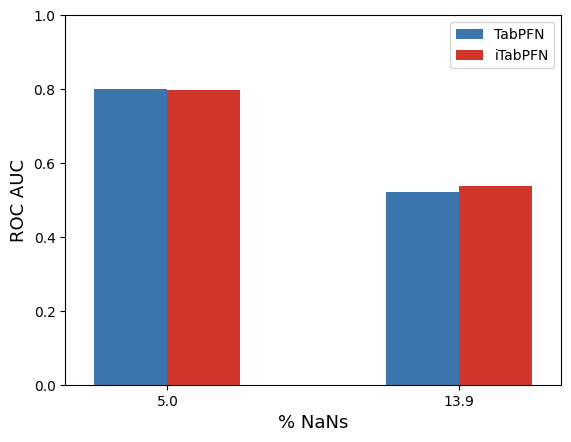

In [42]:
chart4 = df_[(df_.method=='TabPFN') & (df_.nan_prob > 0.04)].sort_values(by=['nan_prob'])
chart4['nan_prob'] = chart4['nan_prob'].multiply(100)
chart4['nan_prob'] = chart4['nan_prob'].round(1)
ax4 = chart4.plot.bar(x = 'nan_prob', y='metric', color = '#3C76AF', alpha = 1, width = 0.25, position = 1, label = 'TabPFN')

ichart4 = df_[(df_.method=='iTabPFN') & (df_.nan_prob > 0.04)].sort_values(by=['nan_prob'])
ichart4['nan_prob'] = ichart4['nan_prob'].multiply(100)
ichart4['nan_prob'] = ichart4['nan_prob'].round(1)
ichart4 = ichart4.plot.bar(x = 'nan_prob', y='metric', ax = ax4, color = '#D0352B', alpha = 1, width = 0.25, position = 0, label = 'iTabPFN', rot = 0)

iichart4 = df_[(df_.method=='iTabPFN') & (df_.nan_prob > 0.04)].sort_values(by=['nan_prob'])
iichart4['nan_prob'] = iichart4['nan_prob'].multiply(100)
iichart4['nan_prob'] = iichart4['nan_prob'].round(1)
iichart4 = iichart4.plot(x = 'nan_prob', y='metric', kind = 'bar', ax = ax4, color = '#D0352B', alpha = 0, width = 0.2, position = 0.5, label = '_', rot = 0)

ichart4.set_xlabel("% NaNs", fontsize = 13)
ichart4.set_ylabel("ROC AUC", fontsize = 13)
ichart4.set_ylim(0, 1.0)

## Table metrics

In [43]:
methods_table = [
                 'knn',
                 'logistic',
                 'gp',
                 'lgbm',
                 'xgb',
                 'autosklearn',
                 'autosklearn2',
                 'tab_transformer',
                 'i_transformer_2_1',]

In [44]:
def bold_extreme_values(data, format_string="%.5g", max_=True):
    data = data.astype(float).round(4)
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

def to_str(data, format_string="%.3g", drop=False):
    if drop:
        formatted = data.apply(lambda x : (format_string % x)[1:])
    else:
        formatted = data.apply(lambda x : (format_string % x))
    return formatted

### No categorical ft.

In [45]:
max_time = '1800' 
metric_used = tabular_metrics.auc_metric

In [46]:
global_results_filtered = {**global_results}
global_results_filtered = {k: global_results_filtered[k] for k in global_results_filtered.keys() if '_time_'+str(max_time)+tabular_baselines.get_scoring_string(metric_used, usage='')+'_' in k}

In [47]:
# here we take datasets with no categ and no NANs
test_datasets_multiclass_filtered = test_datasets
test_datasets_multiclass_filtered_ = [ds for ds in test_datasets_multiclass_filtered if len(ds[3]) == 0 and not torch.isnan(ds[1]).any()]
test_datasets_multiclass_filtered = test_datasets_multiclass_filtered_

print(f"{len(test_datasets)}: test_datasets") # 30
print(f"{len(test_datasets_multiclass_filtered)}: test_datasets_multiclass_filtered") # 18

30: test_datasets
18: test_datasets_multiclass_filtered


In [48]:
def rename(table):
    return table.rename(columns=relabeler)

def get_suffix(i, k):
    suffix = ''
    suffix = suffix+'s' if test_datasets[i][5]['samples_capped'] == True else suffix
    suffix = suffix+'f' if test_datasets[i][5]['feats_capped'] == True else suffix
    suffix = suffix+'c' if test_datasets[i][5]['classes_capped'] == True else suffix
    suffix = '' if len(suffix) == 0 else f' [{suffix}]'
    
    return k + suffix

In [49]:


sum_matrix, sum_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'count', test_datasets_multiclass_filtered)
roc_matrix, roc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'roc', test_datasets_multiclass_filtered)
acc_matrix, acc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'acc', test_datasets_multiclass_filtered)
cross_entropy_matrix, cross_entropy_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'cross_entropy', test_datasets_multiclass_filtered)
time_matrix, time_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'time', test_datasets_multiclass_filtered)

roc_rank, rocs_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())

cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())
roc_matrix_norm = ((roc_matrix.T - roc_matrix.min(1)) / (roc_matrix.max(1) - roc_matrix.min(1))).T

In [50]:
roc_or_ce_matrix = roc_matrix.copy()
roc_or_ce_matrix[roc_matrix.isna()] = -cross_entropy_matrix[roc_matrix.isna()]
roc_or_ce_matrix_stds = roc_matrix_stds
roc_or_ce_matrix_stds[roc_matrix.isna()] = cross_entropy_matrix_stds[roc_matrix.isna()]
roc_or_ce_rank, roc_or_ce_wins = make_ranks_and_wins_table(roc_or_ce_matrix.copy())

In [51]:
def wins_vs_idx(matrix, idx):
    wins_auc = np.array([[(matrix.values[:, j] < matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    ties_auc = np.array([[(matrix.values[:, j] == matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    losses_auc = np.array([[(matrix.values[:, j] > matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    
    return wins_auc, ties_auc, losses_auc

transformer_idx = np.where((roc_matrix.columns == 'i_transformer_2_1') | (roc_matrix.columns == 'i_transformer_2_1'))[0][0]

wins_roc_or_ce_vs_us, ties_roc_or_ce_vs_us, losses_roc_or_ce_vs_us = wins_vs_idx(roc_or_ce_matrix.round(3), transformer_idx)
wins_roc_vs_us, ties_roc_vs_us, losses_roc_vs_us = wins_vs_idx(roc_matrix.round(3), transformer_idx)
wins_acc_vs_us, ties_acc_vs_us, losses_acc_vs_us = wins_vs_idx(acc_matrix.round(3), transformer_idx)
wins_ce_vs_us, ties_ce_vs_us, losses_ce_vs_us = wins_vs_idx(-cross_entropy_matrix.round(3), transformer_idx)

#### table full

In [52]:
table = roc_or_ce_matrix.copy()
#table = acc_matrix.copy()
#table = cross_entropy_matrix.copy()

table.index = [get_suffix(i, k) for i, k in enumerate(table.index[0:table.shape[0]])]

table.loc['Wins AUC'] = rocs_wins
table.loc['Wins Acc.'] = acc_wins
table.loc['Wins CE'] = cross_entropy_wins

table.loc['Mean rank AUC'] = roc_rank 
table.loc['Mean rank Acc.'] = acc_rank
table.loc['Mean rank CE'] = cross_entropy_rank

table.loc['Win/T/L AUC vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_roc_vs_us[-1, :], ties_roc_vs_us[-1, :], losses_roc_vs_us[-1, :])]
table.loc['Win/T/L Acc vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_acc_vs_us[-1, :], ties_acc_vs_us[-1, :], losses_acc_vs_us[-1, :])]
table.loc['Win/T/L CE vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_ce_vs_us[-1, :], ties_ce_vs_us[-1, :], losses_ce_vs_us[-1, :])]

table.loc['Mean AUC'] = roc_matrix.mean(skipna=True)
table.loc['Mean AUC Stds'] = roc_matrix_stds.mean(skipna=True)

table.loc['Mean Acc.'] = acc_matrix.mean()
table.loc['Mean Acc. Stds'] = acc_matrix_stds.mean(skipna=True)

table.loc['Mean CE'] = cross_entropy_matrix.mean()
table.loc['Mean CE Stds'] = cross_entropy_matrix_stds.mean()

table.loc['Mean time (s)'] = time_matrix.mean()
if 'knn' in table.columns:
    table.loc['Mean time (s)', 'knn'] = 0.5
if 'logistic' in table.columns:
    table.loc['Mean time (s)', 'logistic'] = 60

try:
    table = table[methods_table]
except Exception as e:
    print(e)
    table = table
rename(table).round(decimals=4)

,KNN,Log. Regr.,GP (RBF),LGBM,XGB,Autosklearn,Autosklearn2,TabPFN,iTabPFN
balance-scale,0.880128,0.961947,0.982953,0.992779,0.993508,0.992976,0.996225,0.99385,0.970759
mfeat-fourier [s],0.970107,0.97676,0.971528,0.979079,0.979838,0.981924,0.982819,0.972363,0.951812
mfeat-karhunen,0.993779,0.995511,0.99453,0.99799,0.998174,0.997172,0.997917,0.99546,0.994385
mfeat-morphological [s],0.951075,0.965633,0.958824,0.960214,0.960918,0.966828,0.967051,0.964001,0.952218
mfeat-zernike [s],0.976083,0.979522,0.979952,0.971425,0.973452,0.977022,0.981022,0.972119,0.94623
diabetes [s],0.805992,0.838969,0.832227,0.827343,0.835206,0.839077,0.838614,0.836862,0.828336
vehicle,0.880704,0.945333,0.900553,0.922338,0.928433,0.942866,0.952402,0.940737,0.908867
analcatdata_authorship,0.999763,0.999965,0.983304,0.999895,0.999882,0.999229,0.999922,0.999993,0.999909
pc4,0.821798,0.892495,0.899391,0.92675,0.932728,0.927804,0.933188,0.929573,0.893102
pc3,0.753406,0.785145,0.794724,0.816804,0.827595,0.82183,0.8278,0.833418,0.812637


In [53]:
keys_max = ["Mean rank CE", "Mean rank Acc.", "Mean rank AUC", "Mean rank AUC OVR", "Mean rank Bal. Acc.", "Mean AUC", "Mean Acc."] 
keys_max = ["Mean AUC", "Mean Acc.", "Wins AUC", "Wins Acc.", "Wins CE"] 

keys_min = ["Mean rank Acc.", "Mean rank AUC", "Mean rank CE", "Mean CE"]

table_latex = rename(table).copy()

table_latex.loc[['Mean CE']] = table_latex.loc[['Mean CE']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)
table_latex.loc[['Mean Acc.']] = table_latex.loc[['Mean Acc.']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)
table_latex.loc[['Mean AUC']] = table_latex.loc[['Mean AUC']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)

table_latex.iloc[0:len(test_datasets_multiclass_filtered)] = table_latex.iloc[0:len(test_datasets_multiclass_filtered)].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[["Mean time (s)"]] = table_latex.loc[["Mean time (s)"]].apply(lambda data : bold_extreme_values(data, format_string="%.4g", max_=False), axis=1)
table_latex.loc[keys_max] = table_latex.loc[keys_max].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[keys_min] = table_latex.loc[keys_min].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex.loc[['Mean CE Stds']] = table_latex.loc[['Mean CE Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
table_latex = table_latex.drop(['Mean CE Stds'])

table_latex.loc[['Mean Acc. Stds']] = table_latex.loc[['Mean Acc. Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
table_latex = table_latex.drop(['Mean Acc. Stds'])

table_latex.loc[['Mean AUC Stds']] = table_latex.loc[['Mean AUC Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean AUC'] = table_latex.loc['Mean AUC'] + '$\pm$' + table_latex.loc['Mean AUC Stds']
table_latex = table_latex.drop(['Mean AUC Stds'])

# table_latex

In [54]:
table_latex.index = table_latex.index.map(lambda x : x if len(x) < 18 else x[0:18]+'..')

In [55]:
print((table_latex.to_latex(escape=False))
      .replace(r"""\begin{tabular}{lllllllll}""", r"""\begin{tabular}{@{\hskip 0mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 0mm}}""")
      .replace("Wins AUC", r"""\midrule
Wins AUC OVO
                            """)
       .replace("Win/T/L AUC", r"""\midrule
Win/T/L AUC
                            """)
      .replace("Mean rank AUC", r"""\midrule
Mean rank AUC OVO
                            """)
            .replace("Mean AUC", r"""\midrule
Mean AUC OVO
                            """)
      .replace("Mean time (s)", r"""\midrule
Mean time (s) 
                            """)
    )

\begin{tabular}{llllllllll}
\toprule
{} &             KNN &       Log. Regr. &        GP (RBF) &            LGBM &                      XGB &      Autosklearn &           Autosklearn2 &                   TabPFN &          iTabPFN \\
\midrule
balance-scale        &          0.8801 &           0.9619 &           0.983 &          0.9928 &                   0.9935 &            0.993 &        \textbf{0.9962} &                   0.9939 &           0.9708 \\
mfeat-fourier [s]    &          0.9701 &           0.9768 &          0.9715 &          0.9791 &                   0.9798 &           0.9819 &        \textbf{0.9828} &                   0.9724 &           0.9518 \\
mfeat-karhunen       &          0.9938 &           0.9955 &          0.9945 &           0.998 &          \textbf{0.9982} &           0.9972 &                 0.9979 &                   0.9955 &           0.9944 \\
mfeat-morphologica.. &          0.9511 &           0.9656 &          0.9588 &          0.9602 &                   0.

#### table small

In [56]:
table_latex = table_latex.drop(columns=['KNN', 'Log. Regr.'])

In [57]:
table_latex_small = table_latex.iloc[-len(keys_min+keys_max)-1-3:]
table_latex_small

,GP (RBF),LGBM,XGB,Autosklearn,Autosklearn2,TabPFN,iTabPFN
Wins AUC,0,0,0,0,\textbf{6},4,1
Wins Acc.,1,1,1,1,\textbf{5},3,1
Wins CE,0,3,2,1,4,\textbf{6},1
Mean rank AUC,5.6111,5.9444,4.3056,4.6111,\textbf{2.1667},3.5,5.8056
Mean rank Acc.,5.1944,5,4.4722,5.3611,4.25,\textbf{3.7222},5.8056
Mean rank CE,6.3611,3.8056,4.4167,5.5556,4.8056,\textbf{2.9722},4.9722
Win/T/L AUC vs Tab..,10/1/7,9/2/7,11/2/5,12/1/5,13/2/3,13/3/2,0/0/0
Win/T/L Acc vs Tab..,10/0/8,10/2/6,12/0/6,8/1/9,11/1/6,16/1/1,0/0/0
Win/T/L CE vs TabP..,4/0/14,12/0/6,10/1/7,8/0/10,8/0/10,16/0/2,0/0/0
Mean AUC,0.916$\pm$.019,0.919$\pm$.012,0.924$\pm$.012,0.924$\pm$.011,\textbf{0.93}$\pm$.01,0.929$\pm$.0091,0.915$\pm$.01


In [58]:
print(table_latex_small.to_latex(escape=False).replace(r"""\begin{tabular}{lllllllll}""", r"""\begin{tabular}{@{\hskip 0mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 0mm}}""")
      .replace("Wins AUC", r"""\midrule
Wins AUC OVO
                            """)
       .replace("Win/T/L AUC", r"""\midrule
Win/T/L AUC
                            """)
      .replace("Mean rank AUC", r"""\midrule
Mean rank AUC OVO
                            """)
            .replace("Mean AUC", r"""\midrule
Mean AUC OVO
                            """)
      .replace("Mean time (s)", r"""\midrule
Mean time (s) 
                            """)
    )

\begin{tabular}{llllllll}
\toprule
{} &        GP (RBF) &            LGBM &                      XGB &     Autosklearn &           Autosklearn2 &                   TabPFN &          iTabPFN \\
\midrule
\midrule
Wins AUC OVO
                                         &               0 &               0 &                        0 &               0 &             \textbf{6} &                        4 &                1 \\
Wins Acc.            &               1 &               1 &                        1 &               1 &             \textbf{5} &                        3 &                1 \\
Wins CE              &               0 &               3 &                        2 &               1 &                      4 &               \textbf{6} &                1 \\
\midrule
Mean rank AUC OVO
                                    &          5.6111 &          5.9444 &                   4.3056 &          4.6111 &        \textbf{2.1667} &                      3.5 &           5.8056 \\
Mean rank 

### Only categorical ft.

In [59]:
# here we take datasets with ONLY categ and no NANs
test_datasets_multiclass_filtered = test_datasets
test_datasets_multiclass_filtered_ = [ds for ds in test_datasets_multiclass_filtered if len(ds[3]) != 0 and not torch.isnan(ds[1]).any()]
test_datasets_multiclass_filtered = test_datasets_multiclass_filtered_

print(f"{len(test_datasets)}: test_datasets") # 30
print(f"{len(test_datasets_multiclass_filtered)}:  test_datasets_multiclass_filtered") # 6


30: test_datasets
6:  test_datasets_multiclass_filtered


In [60]:
def rename(table):
    return table.rename(columns=relabeler)

def get_suffix(i, k):
    suffix = ''
    suffix = suffix+'s' if test_datasets[i][5]['samples_capped'] == True else suffix
    suffix = suffix+'f' if test_datasets[i][5]['feats_capped'] == True else suffix
    suffix = suffix+'c' if test_datasets[i][5]['classes_capped'] == True else suffix
    suffix = '' if len(suffix) == 0 else f' [{suffix}]'
    
    return k + suffix

In [61]:
sum_matrix, sum_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'count', test_datasets_multiclass_filtered)
roc_matrix, roc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'roc', test_datasets_multiclass_filtered)
acc_matrix, acc_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'acc', test_datasets_multiclass_filtered)

cross_entropy_matrix, cross_entropy_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'cross_entropy', test_datasets_multiclass_filtered)
time_matrix, time_matrix_stds, _ = make_metric_matrix(global_results_filtered, methods_table, pos, 'time', test_datasets_multiclass_filtered)

roc_rank, rocs_wins = make_ranks_and_wins_table(roc_matrix.copy())
acc_rank, acc_wins = make_ranks_and_wins_table(acc_matrix.copy())

cross_entropy_rank, cross_entropy_wins = make_ranks_and_wins_table(-cross_entropy_matrix.copy())
roc_matrix_norm = ((roc_matrix.T - roc_matrix.min(1)) / (roc_matrix.max(1) - roc_matrix.min(1))).T

In [62]:
roc_or_ce_matrix = roc_matrix.copy()
roc_or_ce_matrix[roc_matrix.isna()] = -cross_entropy_matrix[roc_matrix.isna()]
roc_or_ce_matrix_stds = roc_matrix_stds
roc_or_ce_matrix_stds[roc_matrix.isna()] = cross_entropy_matrix_stds[roc_matrix.isna()]
roc_or_ce_rank, roc_or_ce_wins = make_ranks_and_wins_table(roc_or_ce_matrix.copy())

In [63]:
def wins_vs_idx(matrix, idx):
    wins_auc = np.array([[(matrix.values[:, j] < matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    ties_auc = np.array([[(matrix.values[:, j] == matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    losses_auc = np.array([[(matrix.values[:, j] > matrix.values[:, i]).sum() if i != j else 0 for i,method in enumerate(methods_table)] for j in [idx]])
    
    return wins_auc, ties_auc, losses_auc

transformer_idx = np.where((roc_matrix.columns == 'i_transformer_2_1') | (roc_matrix.columns == 'i_transformer_2_1'))[0][0]

wins_roc_or_ce_vs_us, ties_roc_or_ce_vs_us, losses_roc_or_ce_vs_us = wins_vs_idx(roc_or_ce_matrix.round(3), transformer_idx)
wins_roc_vs_us, ties_roc_vs_us, losses_roc_vs_us = wins_vs_idx(roc_matrix.round(3), transformer_idx)
wins_acc_vs_us, ties_acc_vs_us, losses_acc_vs_us = wins_vs_idx(acc_matrix.round(3), transformer_idx)
wins_ce_vs_us, ties_ce_vs_us, losses_ce_vs_us = wins_vs_idx(-cross_entropy_matrix.round(3), transformer_idx)

#### table full

In [64]:
table = roc_or_ce_matrix.copy()
#table = acc_matrix.copy()
#table = cross_entropy_matrix.copy()

table.index = [get_suffix(i, k) for i, k in enumerate(table.index[0:table.shape[0]])]

table.loc['Wins AUC'] = rocs_wins
table.loc['Wins Acc.'] = acc_wins
table.loc['Wins CE'] = cross_entropy_wins

table.loc['Mean rank AUC'] = roc_rank
table.loc['Mean rank Acc.'] = acc_rank
table.loc['Mean rank CE'] = cross_entropy_rank

table.loc['Win/T/L AUC vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_roc_vs_us[-1, :], ties_roc_vs_us[-1, :], losses_roc_vs_us[-1, :])]
table.loc['Win/T/L Acc vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_acc_vs_us[-1, :], ties_acc_vs_us[-1, :], losses_acc_vs_us[-1, :])]
table.loc['Win/T/L CE vs TabPFN'] = ["{:d}/{:d}/{:d}".format(w, t, l) for w,t,l in zip(wins_ce_vs_us[-1, :], ties_ce_vs_us[-1, :], losses_ce_vs_us[-1, :])]

table.loc['Mean AUC'] = roc_matrix.mean(skipna=True)
table.loc['Mean AUC Stds'] = roc_matrix_stds.mean(skipna=True)

table.loc['Mean Acc.'] = acc_matrix.mean()
table.loc['Mean Acc. Stds'] = acc_matrix_stds.mean(skipna=True)

table.loc['Mean CE'] = cross_entropy_matrix.mean()
table.loc['Mean CE Stds'] = cross_entropy_matrix_stds.mean()

table.loc['Mean time (s)'] = time_matrix.mean()
if 'knn' in table.columns:
    table.loc['Mean time (s)', 'knn'] = 0.5
if 'logistic' in table.columns:
    table.loc['Mean time (s)', 'logistic'] = 60

try:
    table = table[methods_table]
except Exception as e:
    print(e)
    table = table
rename(table).round(decimals=4)

,KNN,Log. Regr.,GP (RBF),LGBM,XGB,Autosklearn,Autosklearn2,TabPFN,iTabPFN
cmc,0.63415,0.681434,0.672611,0.728381,0.728418,0.737678,0.73779,0.715995,0.705401
credit-g [s],0.726149,0.766505,0.783345,0.769443,0.791625,0.782057,0.79093,0.789546,0.791885
tic-tac-toe,0.985876,0.99576,0.998037,0.998349,0.997474,0.999721,0.996499,0.757651,0.807088
analcatdata_dmft [s],0.543403,0.568535,0.570164,0.542398,0.57229,0.565968,0.577214,0.564449,0.562811
ilpd [s],0.645964,0.739051,0.663069,0.699121,0.713783,0.701406,0.723594,0.730857,0.729371
car [s],0.924391,0.982617,0.885483,0.992448,0.994042,0.99101,0.998225,0.978335,0.956761
Wins AUC,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0
Wins Acc.,0.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0
Wins CE,0.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0
Mean rank AUC,8.333333,5.083333,5.916667,5.333333,3.0,3.916667,2.666667,5.333333,5.416667


In [65]:
keys_max = ["Mean rank CE", "Mean rank Acc.", "Mean rank AUC", "Mean rank AUC OVR", "Mean rank Bal. Acc.", "Mean AUC", "Mean Acc."] 
keys_max = ["Mean AUC", "Mean Acc.", "Wins AUC", "Wins Acc.", "Wins CE"]

keys_min = ["Mean rank Acc.", "Mean rank AUC", "Mean rank CE", "Mean CE"]

table_latex = rename(table).copy()

table_latex.loc[['Mean CE']] = table_latex.loc[['Mean CE']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)
table_latex.loc[['Mean Acc.']] = table_latex.loc[['Mean Acc.']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)
table_latex.loc[['Mean AUC']] = table_latex.loc[['Mean AUC']].apply(lambda data : to_str(data, format_string="%.3g"),axis=1)

table_latex.iloc[0:len(test_datasets_multiclass_filtered)] = table_latex.iloc[0:len(test_datasets_multiclass_filtered)].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[["Mean time (s)"]] = table_latex.loc[["Mean time (s)"]].apply(lambda data : bold_extreme_values(data, format_string="%.4g", max_=False), axis=1)
table_latex.loc[keys_max] = table_latex.loc[keys_max].apply(lambda data : bold_extreme_values(data),axis=1)
table_latex.loc[keys_min] = table_latex.loc[keys_min].apply(lambda data : bold_extreme_values(data, max_=False),axis=1)

table_latex.loc[['Mean CE Stds']] = table_latex.loc[['Mean CE Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean CE'] = table_latex.loc['Mean CE'] + '$\pm$' + table_latex.loc['Mean CE Stds']
table_latex = table_latex.drop(['Mean CE Stds'])

table_latex.loc[['Mean Acc. Stds']] = table_latex.loc[['Mean Acc. Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean Acc.'] = table_latex.loc['Mean Acc.'] + '$\pm$' + table_latex.loc['Mean Acc. Stds']
table_latex = table_latex.drop(['Mean Acc. Stds'])

table_latex.loc[['Mean AUC Stds']] = table_latex.loc[['Mean AUC Stds']].apply(lambda data : to_str(data, format_string="%.2g", drop=True),axis=1)
table_latex.loc['Mean AUC'] = table_latex.loc['Mean AUC'] + '$\pm$' + table_latex.loc['Mean AUC Stds']
table_latex = table_latex.drop(['Mean AUC Stds'])

# table_latex

In [66]:
table_latex.index = table_latex.index.map(lambda x : x if len(x) < 18 else x[0:18]+'..')

In [67]:
print((table_latex.to_latex(escape=False))
      .replace(r"""\begin{tabular}{lllllllll}""", r"""\begin{tabular}{@{\hskip 0mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 0mm}}""")
      .replace("Wins AUC", r"""\midrule
Wins AUC OVO
                            """)
       .replace("Win/T/L AUC", r"""\midrule
Win/T/L AUC
                            """)
      .replace("Mean rank AUC", r"""\midrule
Mean rank AUC OVO
                            """)
            .replace("Mean AUC", r"""\midrule
Mean AUC OVO
                            """)
      .replace("Mean time (s)", r"""\midrule
Mean time (s) 
                            """)
    )

\begin{tabular}{llllllllll}
\toprule
{} &             KNN &       Log. Regr. &        GP (RBF) &            LGBM &                      XGB &      Autosklearn &             Autosklearn2 &          TabPFN &          iTabPFN \\
\midrule
cmc                  &          0.6342 &           0.6814 &          0.6726 &          0.7284 &                   0.7284 &           0.7377 &          \textbf{0.7378} &           0.716 &           0.7054 \\
credit-g [s]         &          0.7261 &           0.7665 &          0.7833 &          0.7694 &                   0.7916 &           0.7821 &                   0.7909 &          0.7895 &  \textbf{0.7919} \\
tic-tac-toe          &          0.9859 &           0.9958 &           0.998 &          0.9983 &                   0.9975 &  \textbf{0.9997} &                   0.9965 &          0.7577 &           0.8071 \\
analcatdata_dmft [.. &          0.5434 &           0.5685 &          0.5702 &          0.5424 &                   0.5723 &            0.566 &   

#### table small

In [68]:
table_latex = table_latex.drop(columns=['KNN', 'Log. Regr.'])

In [69]:
table_latex_small = table_latex.iloc[-len(keys_min+keys_max)-1-3:]
table_latex_small

,GP (RBF),LGBM,XGB,Autosklearn,Autosklearn2,TabPFN,iTabPFN
Wins AUC,0,0,0,1,\textbf{2},0,0
Wins Acc.,0,1,1,0,\textbf{2},1,0
Wins CE,0,1,\textbf{2},0,1,1,0
Mean rank AUC,5.9167,5.3333,3,3.9167,\textbf{2.6667},5.3333,5.4167
Mean rank Acc.,6.4167,4.3333,\textbf{2.6667},5.0833,4.0833,5.3333,5
Mean rank CE,6.6667,4.3333,\textbf{2.9167},4.8333,4.8333,4.8333,4.5
Win/T/L AUC vs Tab..,2/0/4,3/0/3,4/1/1,4/0/2,4/0/2,4/0/2,0/0/0
Win/T/L Acc vs Tab..,3/0/3,3/0/3,4/0/2,3/0/3,3/0/3,3/0/3,0/0/0
Win/T/L CE vs TabP..,1/0/5,3/0/3,4/0/2,3/0/3,3/0/3,3/0/3,0/0/0
Mean AUC,0.762$\pm$.034,0.788$\pm$.015,0.8$\pm$.014,0.796$\pm$.0097,\textbf{0.804}$\pm$.013,0.756$\pm$.015,0.759$\pm$.014


In [70]:
print(table_latex_small.to_latex(escape=False).replace(r"""\begin{tabular}{lllllllll}""", r"""\begin{tabular}{@{\hskip 0mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 1mm}
l@{\hskip 0mm}}""")
      .replace("Wins AUC", r"""\midrule
Wins AUC OVO
                            """)
       .replace("Win/T/L AUC", r"""\midrule
Win/T/L AUC
                            """)
      .replace("Mean rank AUC", r"""\midrule
Mean rank AUC OVO
                            """)
            .replace("Mean AUC", r"""\midrule
Mean AUC OVO
                            """)
      .replace("Mean time (s)", r"""\midrule
Mean time (s) 
                            """)
    )

\begin{tabular}{llllllll}
\toprule
{} &        GP (RBF) &            LGBM &                      XGB &      Autosklearn &             Autosklearn2 &          TabPFN &         iTabPFN \\
\midrule
\midrule
Wins AUC OVO
                                         &               0 &               0 &                        0 &                1 &               \textbf{2} &               0 &               0 \\
Wins Acc.            &               0 &               1 &                        1 &                0 &               \textbf{2} &               1 &               0 \\
Wins CE              &               0 &               1 &               \textbf{2} &                0 &                        1 &               1 &               0 \\
\midrule
Mean rank AUC OVO
                                    &          5.9167 &          5.3333 &                        3 &           3.9167 &          \textbf{2.6667} &          5.3333 &          5.4167 \\
Mean rank Acc.       &          6.4167 &     

## OpenML-CC18 datasets

In [71]:
# open_cc_dids

In [72]:
df_1 = []
for i, dss in [(x, test_datasets[x][0]) for x in range(len(test_datasets))]:
        df_1 += [{'OpenML ID': open_cc_dids[i]
                 ,'Name': dss
                 ,'# Datapoints': test_datasets[i][1].shape[0]
                 ,'# Features': test_datasets[i][1].shape[1]
                 ,'# Categorical ft.': len(test_datasets[i][3])
                 ,'# NANs': int(float(torch.count_nonzero(torch.isnan(test_datasets[i][1]).float())))
                 ,'# Classes': len(np.unique(test_datasets[i][2]))
                 }]

In [73]:
df_1 = pd.DataFrame(df_1)

In [74]:
df_1

,OpenML ID,Name,# Datapoints,# Features,# Categorical ft.,# NANs,# Classes
0,11,balance-scale,625,4,0,0,3
1,14,mfeat-fourier,2000,76,0,0,10
2,15,breast-w,699,9,0,16,2
3,16,mfeat-karhunen,2000,64,0,0,10
4,18,mfeat-morphological,2000,6,0,0,10
5,22,mfeat-zernike,2000,47,0,0,10
6,23,cmc,1473,9,7,0,3
7,29,credit-approval,690,15,9,67,2
8,31,credit-g,1000,20,13,0,2
9,37,diabetes,768,8,0,0,2


In [75]:
dataset_table = df_1.copy()

In [76]:
print(dataset_table.to_latex(escape=False))

\begin{tabular}{lrlrrrrr}
\toprule
{} &  OpenML ID &                              Name &  # Datapoints &  # Features &  # Categorical ft. &  # NANs &  # Classes \\
\midrule
0  &         11 &                     balance-scale &           625 &           4 &                  0 &       0 &          3 \\
1  &         14 &                     mfeat-fourier &          2000 &          76 &                  0 &       0 &         10 \\
2  &         15 &                          breast-w &           699 &           9 &                  0 &      16 &          2 \\
3  &         16 &                    mfeat-karhunen &          2000 &          64 &                  0 &       0 &         10 \\
4  &         18 &               mfeat-morphological &          2000 &           6 &                  0 &       0 &         10 \\
5  &         22 &                     mfeat-zernike &          2000 &          47 &                  0 &       0 &         10 \\
6  &         23 &                               cmc &